# Binary classification of sequences into SP or Non-SP using transformer embedding and Gradient Boosting (XGBoost)

#### Imports and dependancies

In [3]:
%pip install transformers
%pip install xgboost
import pandas as  pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score, roc_auc_score
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import os


#### Constants

In [4]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/PBLRost/"
FASTA_PATH = os.path.join(DRIVE_PATH, "data/complete_set_unpartitioned.fasta")
MODEL = "Rostlab/prot_bert"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from transformers import BertTokenizer, T5EncoderModel # Import BertTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL) # Use BertTokenizer
encoder = AutoModel.from_pretrained(MODEL).to(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

#### Embedding function using transformer

In [5]:
def get_prostt5_embeddings_batched(sequences, batch_size=8):
    embeddings = []
    formatted = [" ".join(list(seq)) for seq in sequences]  # ProstT5 expects space-separated AAs

    with torch.no_grad():
        for i in tqdm(range(0, len(formatted), batch_size)):
            batch_seqs = formatted[i:i+batch_size]
            encoded = tokenizer(batch_seqs, return_tensors="pt", padding=True, truncation=True, max_length=512)
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)
            # ProstT5: outputs.last_hidden_state shape = (batch, seq_len, hidden)
            batch_embs = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # average pooling
            embeddings.extend(batch_embs)

    return np.array(embeddings)

def get_protbert_embeddings_batched(sequences, batch_size=16):
    embeddings = []

    # space-separated amino acids (ProtBERT requirement)
    formatted = [" ".join(list(seq)) for seq in sequences]

    with torch.no_grad():
        for i in tqdm(range(0, len(formatted), batch_size)):
            batch_seqs = formatted[i:i+batch_size]
            encoded = tokenizer(batch_seqs, return_tensors="pt", padding=True, truncation=True, max_length=512)

            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)
            batch_embs = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # average pooling
            embeddings.extend(batch_embs)

    return np.array(embeddings)

#### Data loading and prep (including embedding)

In [7]:
def load_and_prep_data(dataPath: str):
    records = []
    with open(dataPath, "r") as f:
        current_record = {}
        for line in f:
            if line.startswith(">"):
                if current_record:
                    records.append(current_record)
                header = line[1:].strip().split("|")
                if len(header) == 3:
                    current_record = {
                        "uniprot_ac": header[0],
                        "kingdom": header[1],
                        "type": header[2],
                        "sequence": ""
                    }
                else:
                    current_record = {}
            elif current_record:
                if not current_record.get("sequence"):
                    current_record["sequence"] = line.strip()
    if current_record:
        records.append(current_record)
    df_raw = pd.DataFrame(records)

    # drop na rows
    df_raw.dropna(subset=['sequence', 'type'], inplace=True)

    # Remove records with 'P' in sequence (if needed)
    df = df_raw[~df_raw["sequence"].str.contains("P")].copy()

    # 4-state labeling
    df["type"] = df["type"].replace({
        "NO_SP": "0",
        "LIPO": "1",
        "SP": "2",
        "TAT": "3",
        "TATLIPO": "3" # TAT and TATLIPO both have label T
    })

    df_majority = df[df["type"] == "0"]
    df_minority = df[(df["type"] == "1") | (df["type"] == "2") | (df["type"] == "3")]

    # randomly oversample the data to equalize the NO_SP to SP ratio
    if not df_minority.empty and not df_majority.empty:
        df_minority_upsampled = resample(
            df_minority,
            replace=True,
            n_samples=len(df_majority),
            random_state=42
        )
        df_balanced = pd.concat([df_majority, df_minority_upsampled])
    else:
        df_balanced = df.copy()

    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Total records after oversampling: {len(df_balanced)}")
    print("Class distribution after oversampling:")
    print(df_balanced["type"].value_counts())

    """
    # randomly undersample the majority class to match the minority class size
    if not df_minority.empty and not df_majority.empty:
        df_majority_undersampled = resample(
            df_majority,
            replace=False,
            n_samples=len(df_minority),
            random_state=42
        )
        df_balanced = pd.concat([df_majority_undersampled, df_minority])
    else:
        df_balanced = df.copy()

    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Total records after undersampling: {len(df_balanced)}")
    print("Class distribution after undersampling:")
    print(df_balanced["type"].value_counts())
    """

    sequences = df_balanced["sequence"].tolist()
    labels = df_balanced["type"].astype(int).tolist()

    # get embeddings from bert
    finSeqs = get_protbert_embeddings_batched(sequences, batch_size=16)
    finLabels = np.array(labels)

    # each part
    train_seqs, test_seqs, train_types, test_types = train_test_split(
        finSeqs, finLabels, test_size=0.2, random_state=42, stratify=finLabels
    )

    print(f"Training set size: {len(train_seqs)}")
    print(f"Test set size: {len(test_seqs)}")

    return train_seqs, test_seqs, train_types, test_types

train_seqs, test_seqs, train_types, test_types = load_and_prep_data(FASTA_PATH)

Total records after oversampling: 1710
Class distribution after oversampling:
type
0    855
1    485
2    355
3     15
Name: count, dtype: int64


100%|██████████| 107/107 [28:36<00:00, 16.05s/it]

Training set size: 1368
Test set size: 342


#### Model def and training

In [8]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    use_label_encoder=False
)

model.fit(train_seqs, train_types)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)


#### Model eval

Accuracy: 0.991
Precision (weighted): 0.991
Recall (weighted): 0.991
F1 Score (weighted): 0.991
Matthews Correlation Coefficient: 0.986

Classification Report:
              precision    recall  f1-score   support

           0     0.9884    1.0000    0.9942       171
           1     0.9898    1.0000    0.9949        97
           2     1.0000    0.9577    0.9784        71
           3     1.0000    1.0000    1.0000         3

    accuracy                         0.9912       342
   macro avg     0.9946    0.9894    0.9919       342
weighted avg     0.9913    0.9912    0.9912       342



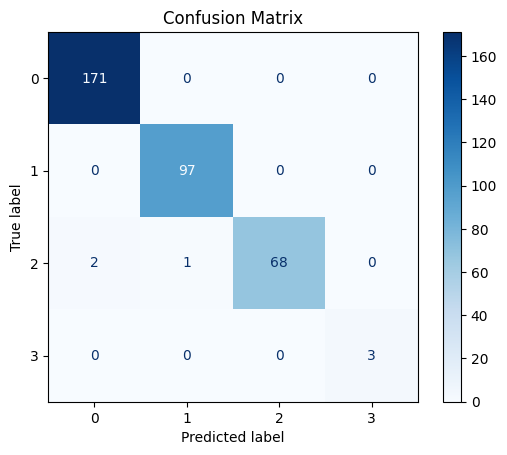

ROC AUC (macro): 1.0


In [9]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Predictions
pred_types = model.predict(test_seqs)

# Basic metrics
print("Accuracy:", round(accuracy_score(test_types, pred_types), 3))
print("Precision (weighted):", round(precision_score(test_types, pred_types, average='weighted'), 3))
print("Recall (weighted):", round(recall_score(test_types, pred_types, average='weighted'), 3))
print("F1 Score (weighted):", round(f1_score(test_types, pred_types, average='weighted'), 3))
print("Matthews Correlation Coefficient:", round(matthews_corrcoef(test_types, pred_types), 3))

# Classification Report
print("\nClassification Report:")
print(classification_report(test_types, pred_types, digits=4))

# Confusion Matrix
cm = confusion_matrix(test_types, pred_types)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC AUC (macro-averaged, if predict_proba available)
if hasattr(model, "predict_proba"):
    try:
        proba = model.predict_proba(test_seqs)
        roc_auc = roc_auc_score(test_types, proba, multi_class='ovr', average='macro')
        print("ROC AUC (macro):", round(roc_auc, 3))
    except ValueError:
        print("ROC AUC: Not computable (check label/proba format)")
